# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
target = TuringTarget(funnel_model; d=d, compute_MAP=false)
true_target = TuringTarget(true_model; d=d, compute_MAP=false);

In [6]:
spl = MCHMC(10_000, 0.01; sigma=ones(d))
@time samples_mchmc = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 1.5485444482397266
[ Info: L: 1.1647056424318936
[ Info: nu: 0.8717507041243856
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: false
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:03

 12.050468 seconds (50.76 M allocations: 14.135 GiB, 16.23% gc time, 57.12% compilation time: 2% of which was recompilation)


In [7]:
spl = MCHMC(10_000, 0.01; adaptive=true, sigma=ones(d))
@time samples_mchmc_adaptive = Sample(spl, target, 100_000; dialog=false);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:00[ Info: eps: 1.456195024751741
[ Info: L: 1.0570576760753894
[ Info: nu: 0.9071877535266873
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:03

  4.898215 seconds (37.62 M allocations: 13.138 GiB, 19.75% gc time)


In [8]:
#spl_ensemble = MCHMC(0.0, 0.0, 10; init_eps=0.3, varE_wanted=0.1, sigma=ones(d))
#@time samples_mchmc_ensemble = Sample(spl_ensemble, target, 10_000;
#                            burn_in=500, dialog=false);

In [9]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];
VarE = std(E)^2/d

0.02777702088431338

In [10]:
ESSs, rhat = Summarize(samples_mchmc)
ESS = mean(ESSs)
ESS/4.345784

4700.420879566694

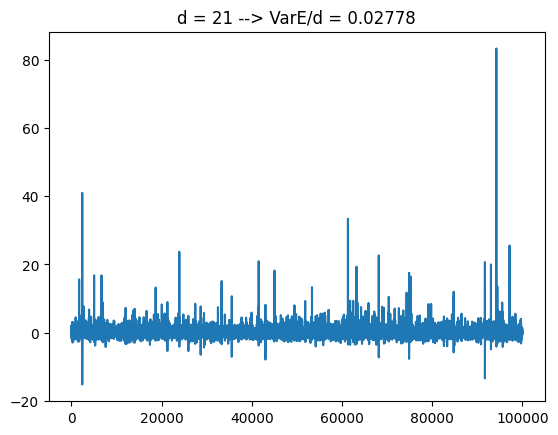

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.02778')

In [11]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

In [12]:
theta_mchmc_adaptive = [sample[1] for sample in samples_mchmc_adaptive]
x10_mchmc_adaptive = [sample[10+1] for sample in samples_mchmc_adaptive]
E_adaptive = [sample[end-1] for sample in samples_mchmc_adaptive]
VarE_adaptive = std(E_adaptive)^2/d

0.014187977550137716

In [13]:
ESSs_adaptive, rhat = Summarize(samples_mchmc_adaptive)
ESS_adaptive = mean(ESSs_adaptive)
ESS_adaptive/4.739692

4712.467174757151

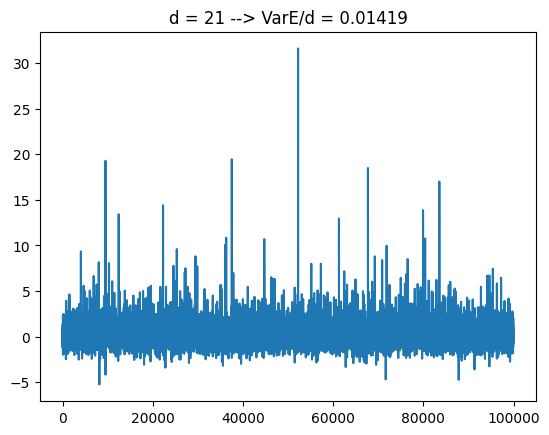

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 0.01419')

In [14]:
plt.plot(E_adaptive, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE_adaptive, digits=5)))

In [15]:
theta_mchmc_ensemble = [sample[1] for sample in samples_mchmc_ensemble]
x10_mchmc_ensemble = [sample[10+1] for sample in samples_mchmc_ensemble]
E_ensemble = [sample[end-1] for sample in samples_mchmc_ensemble]
VarE_ensemble = std(E_ensemble)^2/d

LoadError: UndefVarError: `samples_mchmc_ensemble` not defined

In [16]:
ESSs_ensemble, rhat = Summarize(samples_mchmc_ensemble)
ESS_ensemble = mean(ESSs_ensemble)
ESS_ensemble/6.055317

LoadError: UndefVarError: `samples_mchmc_ensemble` not defined

In [17]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(x10_mchmc_ensemble, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHCM- Ensemble")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(theta_mchmc_ensemble, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(x10_mchmc_ensemble, theta_mchmc_ensemble, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Ensemble - MCHMC")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;

LoadError: UndefVarError: `x10_mchmc_ensemble` not defined

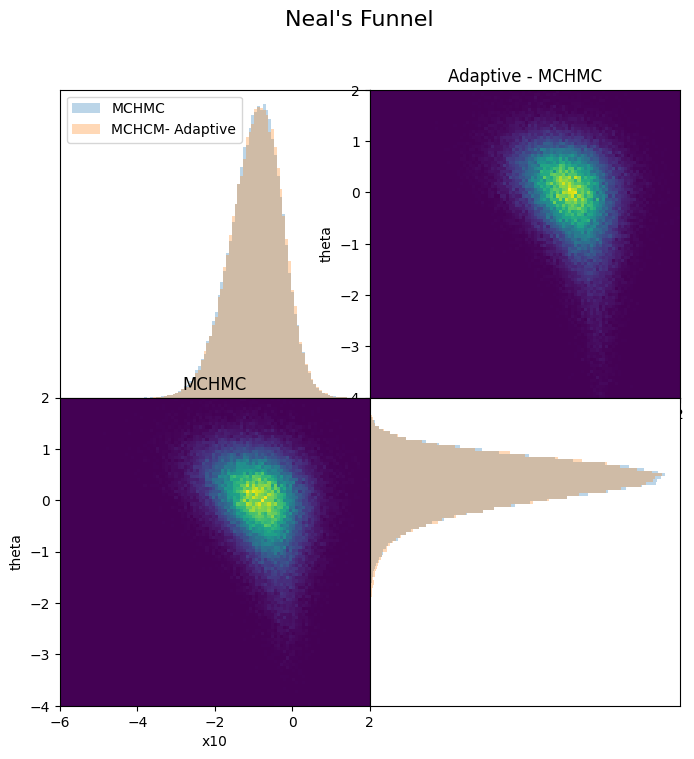

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHCM- Adaptive")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(x10_mchmc_adaptive, theta_mchmc_adaptive, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Adaptive - MCHMC")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;

## NUTS

In [19]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 3.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 22.14 seconds
Compute duration  = 22.14 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0427    0.7914     0.0035    0.0123    3652.3995    1.0000   ⋯
        z[1]    0.3597    0.7141     0.0032    0.0032   57842.5516    1.0000   ⋯
        z[2]   -0.3558    0.7120     0.0032    0.0032   56396.2394    1.0000   ⋯
        z[3]   -0.6

In [20]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 39.43 seconds
Compute duration  = 39.43 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0646    0.8807     0.0039    0.0088   10715.6783    1.0001   ⋯
        z[1]    0.3396    0.7066     0.0032    0.0024   90040.0083    1.0000   ⋯
        z[2]   -0.3397    0.7114     0.0032    0.0025   84820.9556    1.0000   ⋯
        z[3]   -0.6

In [21]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [22]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


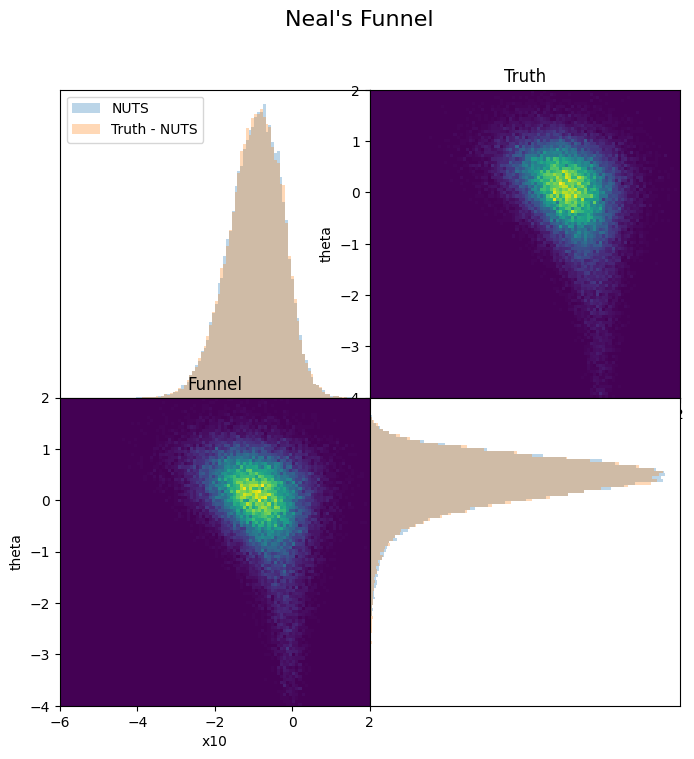

In [23]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

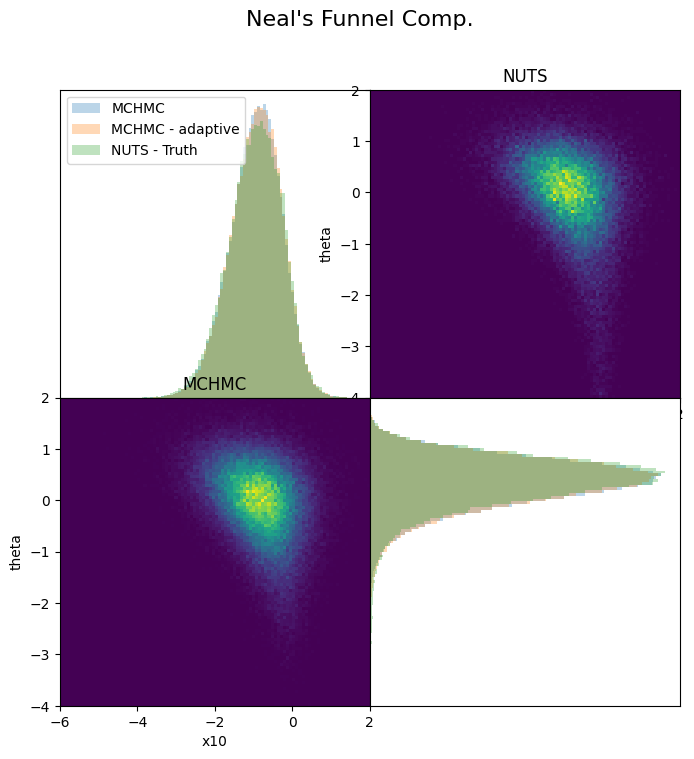

In [24]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_mchmc_adaptive, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC - adaptive")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc_adaptive, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;